## Data Sources:

DB1: [IMDB Dataset](https://datasets.imdbws.com/) - movies, principal actors, reviews.

DB2: [Movie Dynamics](https://www.kaggle.com/datasets/michaelfire/movie-dynamics-over-15000-movie-social-networks) - contains graph networks of ~15K, used a resource for the full cast list.

## Initializations and Presets

In [2]:
!pip -q install kaggle
!pip -q install tslearn

In [233]:
# For debug, an external repository is used to store the dataset object after initialziation.
# These two properties can be set to False and ""
USE_GOOGLE_DRIVE_FOR_FILES    = True
SAVED_OBJECT_FOLDER_PATH   = "/content/drive/My Drive/Data Science/BGU/BigData/Project/saved_objects"

# Paths
BASE_IMDB_DATASET_URL         = "https://datasets.imdbws.com"
DB1_PATH                      = "./datasets/IMDB"
DB2_PATH                      = "./datasets/movie-dynamics/moviedynamics"

# Seed to be used for clustering and others.
SEED                          = 42

# Career length definition for clustering.
CAREER_LENGTH                 = 20

# Palette of colors to be used when showing movie features plots.
ONEHOT_FEATURES_PALETTE = ['thistle', 'blueviolet', 'lightgreen', 'mediumseagreen']


import pandas as pd
import numpy as np
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pickle
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from PIL import Image
from io import BytesIO
import requests
from bs4 import BeautifulSoup
from itertools import chain
from datetime import datetime

if USE_GOOGLE_DRIVE_FOR_FILES:
  from google.colab import drive
  drive.mount('/content/drive')

plt.style.use('ggplot')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Utility Functions

In [4]:

def download_file(url, download_dir):
    """
    Download a file from the given URL and save it to the specified directory.

    Args:
        url (str): The URL of the file to download.
        download_dir (str): The directory to save the downloaded file.
    """
    # Create the directory if it doesn't exist
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    # Extract the file name from the URL
    file_name = url.split('/')[-1]

    # Path to save the downloaded file
    file_path = os.path.join(download_dir, file_name)

    # Download the file
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the file
        with open(file_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded {file_name} successfully!")
    else:
        print(f"Failed to download {file_name}. Status code: {response.status_code}")

## Datasets Initialization

### Movie Dynamics Dataset

In [5]:
api_token = {"username":"xxx","key":"yyy"}

# creating kaggle.json file with the personal API-Key details
!mkdir /root/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download michaelfire/movie-dynamics-over-15000-movie-social-networks -p ./datasets/movie-dynamics
!unzip -q ./datasets/movie-dynamics/movie-dynamics-over-15000-movie-social-networks.zip -d ./datasets/movie-dynamics/

 92% 27.0M/29.5M [00:01<00:00, 36.7MB/s]
100% 29.5M/29.5M [00:01<00:00, 23.9MB/s]


In [6]:
# a method to extract the movie-dynamics files and arrange them as two dataframes of movies and actors.
def extract_DB2_data():

  def extract_DB2_file(movie_file_name):

      with open(f'{DB2_PATH}/{movie_file_name}', 'r') as file:
          json_actors = json.load(file)

      imdb_rating, movie_name, movie_year = json_actors['graph'].values()
      movie_actors = [item['id'] for item in json_actors['nodes']]
      return movie_name.lower().strip(), movie_year, imdb_rating, movie_actors

  print(f"Extracting {DB2_PATH} data")

  # load movie filenames
  movie_files = os.listdir(DB2_PATH)

  # keep only the actors files
  movie_files = [item for item in movie_files if '.actors.json' in item]


  movies=[]
  actors=[[],[]]

  # for each file
  for movie_file_name in tqdm(movie_files):

    # extract data into lists
    movie_name, movie_year, imdb_rating, movie_actors = extract_DB2_file(movie_file_name)
    movie_key = f'{movie_name}_{movie_year}'
    movies.append([movie_name, movie_year, imdb_rating, movie_key])
    actors[0].extend([movie_key]* len(movie_actors))
    actors[1].extend(movie_actors)

  # create dataframes
  df_movies = pd.DataFrame(data=movies, columns=['movie_name','movie_year', 'imdb_rating', 'key'])
  df_actors = pd.DataFrame(data=zip(*actors), columns=['key','actor_name'])

  return df_movies, df_actors

### IMDB Dataset

The **IMDbDataset** class:

1. Downloads the TSV files from the IMDB website.
2. Filters the data by several criteria, among which:

  a. Movies that appear in the movie-dynamics dataset.

  b. Movies with more than 2K votes.

3. Sets criteria for **principal actor**. A principal actor is an actor that appears in the principal IMDB table, with an order <=5.
4. The object hold the **movies** and **actors** dataframes with the integrated data.



In [7]:
class IMDbDataset(object):

    def __init__(self):
        self.download_data()
        self.foreign_data = extract_DB2_data()
        self.init_properties()

    def init_properties(self):
      """
      Initialize the movies and actors dataframes.
      """

      ###### ratings ######
      df = self.dataframes['title.ratings.tsv']
      self._ratings = df[df.numVotes>2_000].copy()


      ###### movies ######

      df = self.dataframes['title.basics.tsv']

      # filter based on ratings
      self._movies = df.merge(self._ratings.tconst, on='tconst')

      # take only movies
      self._movies = self._movies[self._movies.titleType=='movie']

      # cast
      self._movies.startYear = self._movies.startYear.astype(int)

      # set key
      self._movies['key'] = self._movies.primaryTitle.str.lower() + '_' + self._movies.startYear.astype(str)

      # keep only movies that appear in the foreign data
      f_movies, f_actors = self.foreign_data
      self._movies = self._movies.merge(f_movies['key'], on='key')

      # merge the ratings
      self._movies = self._movies.merge(self._ratings, on='tconst')


      ###### actors ######

      # set actors per movie (take all actors from foreign dataset, and filter by movie key)
      self._actors = f_actors.merge(self._movies[['key', 'tconst']], on='key')

      self.set_principal_actors()

    def __str__(self):
      ret = "IMDB Dataset:\nMovies: {}\nActors: {}\nRatings: {}"
      ret = ret.format(len(self._movies), len(self._actors), len(self._ratings))
      return ret

    def download_data(self):
      """
      Download tsv files from the IMDB website, and create dataframes.
      """
      db_dir = DB1_PATH
      !mkdir "$db_dir"

      tsv_files = ['title.ratings.tsv',
                    'title.basics.tsv',
                    'name.basics.tsv',
                    'title.principals.tsv'
                    ]

      self.dataframes = {}

      for f in tsv_files:

        # download from IMDB site
        url = f"{BASE_IMDB_DATASET_URL}/{f}.gz"
        download_file(url, db_dir)

        # unzip
        !gzip -d "$db_dir/$f"

        # create dataframe
        self.dataframes[f] = pd.read_csv(f'{db_dir}/{f}', sep='\t', na_values=["\\N"])

    def set_principal_actors(self):
      """
      Apply logic to set the principal actors in the actors dataframe
      """

      # from the IMDB principals, filter ones which are not in the selected movies
      df_principals = self.dataframes['title.principals.tsv'].merge(self._movies['tconst'], on='tconst')

      # keep only actors
      df_principals = df_principals[df_principals.category.isin(['actor', 'actress'])]

      # keep only top 5 actors
      df_principals = df_principals[df_principals.ordering<=5]

      # drop duplicates (several actors appear twice in different charachters in the movie)
      df_principals = df_principals.drop(columns=['job','characters','ordering'])
      df_principals = df_principals.drop_duplicates()

      # add the actor's primary name
      df_principals = df_principals.merge(self.dataframes['name.basics.tsv'][['nconst', 'primaryName']], on='nconst')

      # add the movie key
      df_principals = df_principals.merge(self._movies[['tconst', 'key']], on='tconst')

      # left merge with the actors dataframe
      self._actors = self._actors.merge(df_principals[['key', 'primaryName']], left_on=['key', 'actor_name'], right_on=['key', 'primaryName'], how='left')

      # set as a boolean column
      self._actors.rename(columns={'primaryName': 'principal'}, inplace=True)
      self._actors['principal'] = ~self._actors['principal'].isna()

    def save_dataset(self, dir_path):
      """
      Save dataset object
      """
      if not dir_path:
        print("Dataset NOT saved.")
      self.dataframes = None
      with open(f"{dir_path}/ds.pkl", 'wb') as f:
          pickle.dump(ds, f)
      print("Dataset saved.")

    @property
    def ratings(self):
      return self._ratings
    @property
    def movies(self):
      return self._movies
    @property
    def actors(self):
      return self._actors
    @property
    def principals(self):
      return self._principals

    @movies.setter
    def movies(self, value):
        self._movies = value

In [8]:
# Initialize the IMDB dataset object
ds = IMDbDataset()

Downloaded title.ratings.tsv.gz successfully!
Downloaded title.basics.tsv.gz successfully!


<ipython-input-7-0dfb4a2f9adb>:79: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataframes[f] = pd.read_csv(f'{db_dir}/{f}', sep='\t', na_values=["\\N"])


Downloaded name.basics.tsv.gz successfully!
Downloaded title.principals.tsv.gz successfully!
Extracting ./datasets/movie-dynamics/moviedynamics data


100%|██████████| 15538/15538 [00:01<00:00, 10735.72it/s]


In [10]:
print(ds)
ds.save_dataset(SAVED_OBJECT_FOLDER_PATH)

IMDB Dataset:
Movies: 13255
Actors: 157870
Ratings: 53079
Dataset saved.


In [5]:
# load ds
# with open(f"{SAVED_OBJECT_FOLDER_PATH}/ds.pkl", 'rb') as f:
#     ds = pickle.load(f)

## Analyze and add statistics

### Rank movies

This section applies a boolean flag to determine if a movie is top ranked or standard.

The threshold used in the 80 percentile. .

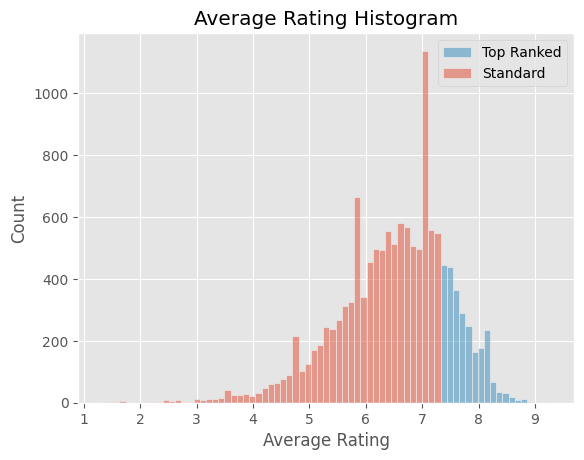

In [21]:
avg_ratings = ds.movies.averageRating.reset_index()
plt.title('Average Rating Histogram');
plt.xlabel('Average Rating')
plt.ylabel('Count');

threshold = np.percentile(avg_ratings.averageRating.values, 80)
avg_ratings['top'] = (avg_ratings['averageRating']>threshold).astype(int)

sns.histplot(data=avg_ratings[['averageRating','top']], x='averageRating', hue='top');
plt.legend(['Top Ranked', 'Standard']);


In [ ]:
# add to the movies dataframe and save
if 'top_ranked' not in ds.movies.columns:
  df_temp = ds.movies
  df_temp['top_ranked'] = avg_ratings.top
  ds.movies = df_temp
  ds.save_dataset(SAVED_OBJECT_FOLDER_PATH)


### Movies count per year

In [49]:
movies_per_year = ds.movies.groupby('startYear').count()['tconst'].reset_index()
movies_rank_per_year = ds.movies.groupby('startYear')['averageRating'].mean().reset_index()

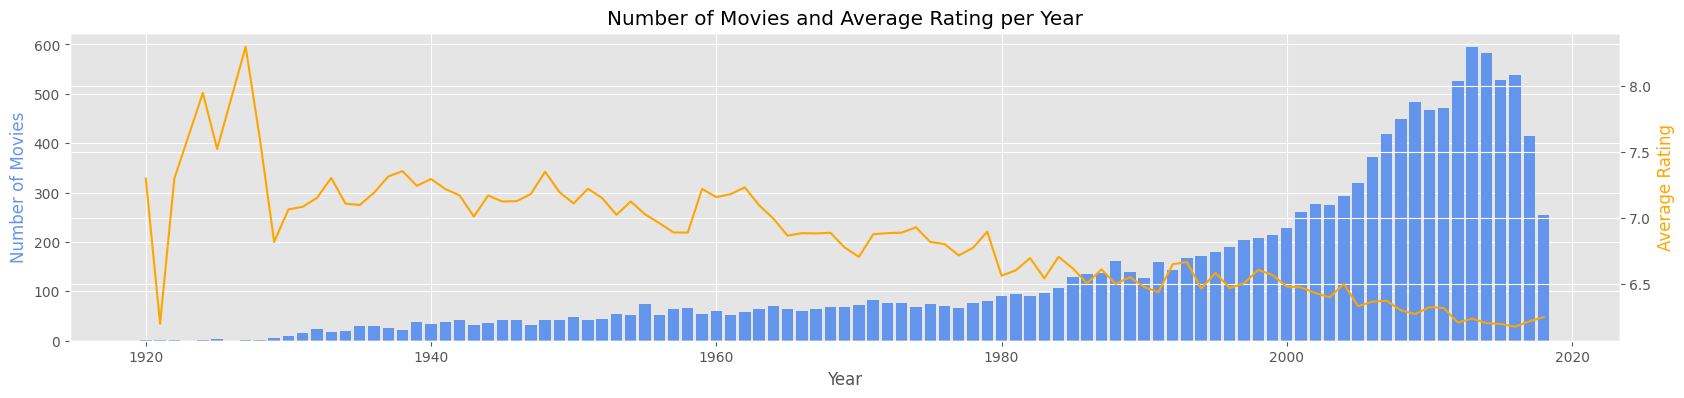

In [58]:
fig, ax1 = plt.subplots(figsize=(20, 4))

# Create bar plot for number of movies per year
ax1.bar(movies_per_year['startYear'], movies_per_year['tconst'], color='cornflowerblue')

# Create a second y-axis for average rating
ax2 = ax1.twinx()
ax2.plot(movies_rank_per_year['startYear'], movies_rank_per_year['averageRating'], color='orange')

# Set labels and title
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Movies', color='cornflowerblue')
ax2.set_ylabel('Average Rating', color='orange')
plt.title('Number of Movies and Average Rating per Year');

### Create a unified data table of movies and actors

In [181]:
# merge actors and movies
df_unified = ds.actors.merge(ds.movies[['tconst', 'primaryTitle', 'startYear', 'top_ranked']])

# cast and rename
df_unified.principal = df_unified.principal.astype(int)
df_unified.rename(columns={'principal': 'top_actor', 'top_ranked': 'top_movie', 'startYear': 'year'}, inplace=True)

# set the top_actor and top_movie columns as one-hot.
df_unified = pd.get_dummies(df_unified, columns=['top_actor', 'top_movie'], dtype=int)
df_unified

,key,actor_name,tconst,primaryTitle,year,top_actor_0,top_actor_1,top_movie_0,top_movie_1
0,obvious child_2014,Jenny Slate,tt2910274,Obvious Child,2014,0,1,1,0
1,obvious child_2014,Jake Lacy,tt2910274,Obvious Child,2014,0,1,1,0
2,obvious child_2014,Paul Briganti,tt2910274,Obvious Child,2014,0,1,1,0
3,obvious child_2014,Gaby Hoffmann,tt2910274,Obvious Child,2014,0,1,1,0
4,manchester by the sea_2016,Michelle Williams,tt4034228,Manchester by the Sea,2016,0,1,0,1
...,...,...,...,...,...,...,...,...,...
157865,beverly hills chihuahua_2008,Axel Alba,tt1014775,Beverly Hills Chihuahua,2008,1,0,1,0
157866,beverly hills chihuahua_2008,Jon Molerio,tt1014775,Beverly Hills Chihuahua,2008,1,0,1,0
157867,beverly hills chihuahua_2008,Eddie 'Piolin' Sotelo,tt1014775,Beverly Hills Chihuahua,2008,1,0,1,0
157868,beverly hills chihuahua_2008,Loretta Devine,tt1014775,Beverly Hills Chihuahua,2008,1,0,1,0


### Actor career length

In [182]:
actors_career_period = df_unified.groupby('actor_name').agg({'year': ['min', 'max', 'count']}).reset_index()
actors_career_period.columns = ['actor_name', 'first_year', 'last_year', 'movie_count']
actors_career_period['total_years'] = actors_career_period.last_year - actors_career_period.first_year + 1
actors_career_period.head()

,actor_name,first_year,last_year,movie_count,total_years
0,Al Freeman Jr.,1968,1992,2,25
1,$hutter,2015,2015,1,1
2,'Arm' Suvinit Pornvalai,1988,1988,1,1
3,'Ducky' Louie,1945,1945,1,1
4,'Freeway' Ricky Ross,2012,2012,1,1


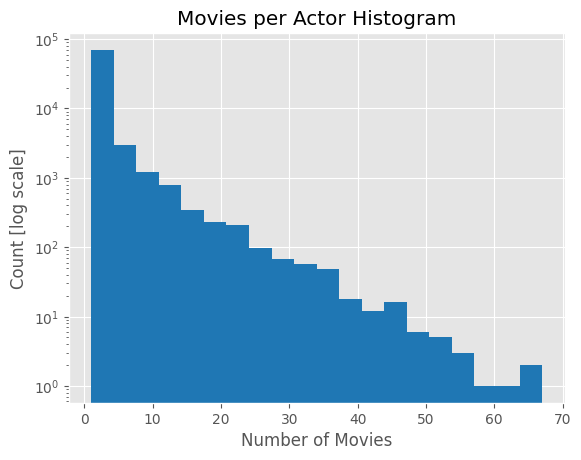

In [66]:
plt.title('Movies per Actor Histogram');
plt.xlabel('Number of Movies')
plt.ylabel('Count [log scale]');
plt.hist(actors_career_period['movie_count'].values, bins=20, color='tab:blue')
plt.yscale('log')


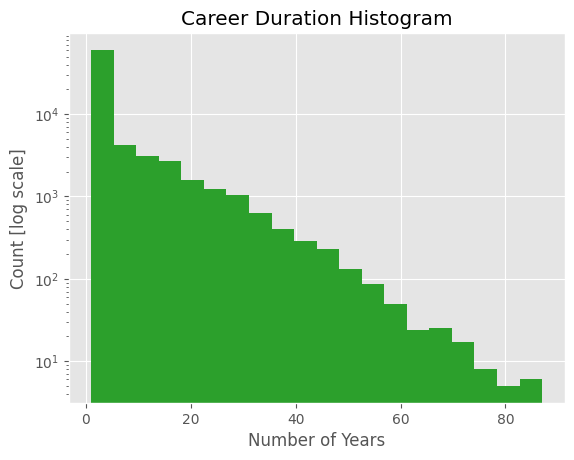

In [67]:
plt.title('Career Duration Histogram');
plt.xlabel('Number of Years')
plt.ylabel('Count [log scale]');
plt.hist(actors_career_period['total_years'].values, bins=20, color='tab:green');
plt.yscale('log')

Filter only actors with career starting at 1970, and with a career of at least 20 years.

In [195]:
actors_career_period_processed = actors_career_period[(actors_career_period.first_year>=1970)&(actors_career_period.total_years>=CAREER_LENGTH)]
actors_career_period_processed = actors_career_period_processed.sort_values(by='actor_name')
actors_career_period_processed

,actor_name,first_year,last_year,movie_count,total_years
9,'Weird Al' Yankovic,1989,2017,3,29
15,A. Michael Baldwin,1979,2016,4,38
22,A.C. Peterson,1991,2012,7,22
60,Aamir Khan,1994,2017,12,24
88,Aaron Eckhart,1997,2016,28,20
...,...,...,...,...,...
75661,Zbigniew Zamachowski,1994,2014,3,21
75687,Zeljko Ivanek,1982,2017,16,36
75916,Ángel López de Andrés,1984,2005,2,22
75918,Ángel Salazar,1983,2002,3,20


In [196]:
def define_years_per_actor(df, max_years):
  """
  returns complete 20-years list per actor
  """
  ret=[]
  for index, row in df.iterrows():
    actor_name, first_year = row[['actor_name','first_year']]
    last_analysis_year = first_year+max_years-1
    years_range = range(first_year,last_analysis_year+1)
    ret.extend(list(zip([actor_name]*len(years_range), years_range)))
  return pd.DataFrame(ret, columns=['actor_name', 'year'])

all_years_per_actor = define_years_per_actor(actors_career_period_processed, max_years=CAREER_LENGTH)

In [197]:
len(all_years_per_actor)

74220

Process the unified actors and movies dataframe:
1. To include 0-value rows for missing years.
2. To have only 20 years per actor.
3. To have only actors from the predefined list.

In [211]:
df_unified_processed = df_unified[df_unified.actor_name.isin(actors_career_period_processed.actor_name.tolist())]
df_unified_processed = df_unified_processed.merge(all_years_per_actor, on=['actor_name','year'], how='right')
df_unified_processed = df_unified_processed.fillna(0)
df_unified_processed['total_movies'] = df_unified_processed['top_movie_0']	+df_unified_processed['top_movie_1']
df_unified_processed.shape

(78287, 10)

Filter out actors with less than 10 movies

In [217]:
total_movies_per_actor = df_unified_processed.groupby('actor_name')['total_movies'].sum().reset_index()
actors_to_keep = total_movies_per_actor[total_movies_per_actor.total_movies>=10].actor_name.tolist()
df_unified_processed = df_unified_processed[df_unified_processed.actor_name.isin(actors_to_keep)]
df_unified_processed.shape

(18336, 10)

### Group and sum into a statistical table

In [220]:
cols = list(df_unified_processed.columns[-5:-1])
df_stats = df_unified_processed.groupby(['actor_name','year']).agg({'top_actor_0': ['sum'],
                                                    'top_actor_1': ['sum'],
                                                    'top_movie_0': ['sum'],
                                                    'top_movie_1': ['sum']}).sort_values(by=['actor_name','year']).reset_index()
df_stats.columns = ['actor_name', 'year'] + cols
df_stats

,actor_name,year,top_actor_0,top_actor_1,top_movie_0,top_movie_1
0,Aaron Eckhart,1997,0.0,1.0,1.0,0.0
1,Aaron Eckhart,1998,0.0,1.0,1.0,0.0
2,Aaron Eckhart,1999,1.0,1.0,2.0,0.0
3,Aaron Eckhart,2000,1.0,1.0,1.0,1.0
4,Aaron Eckhart,2001,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...
15035,Yun-Fat Chow,2001,0.0,0.0,0.0,0.0
15036,Yun-Fat Chow,2002,0.0,0.0,0.0,0.0
15037,Yun-Fat Chow,2003,0.0,0.0,0.0,0.0
15038,Yun-Fat Chow,2004,0.0,0.0,0.0,0.0


The plot below shows the statistics for the chosen careers. As expected, most roles are standard in non top ranked movies.

<ipython-input-579-057e819cc09b>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




Text(0, 0.5, '')

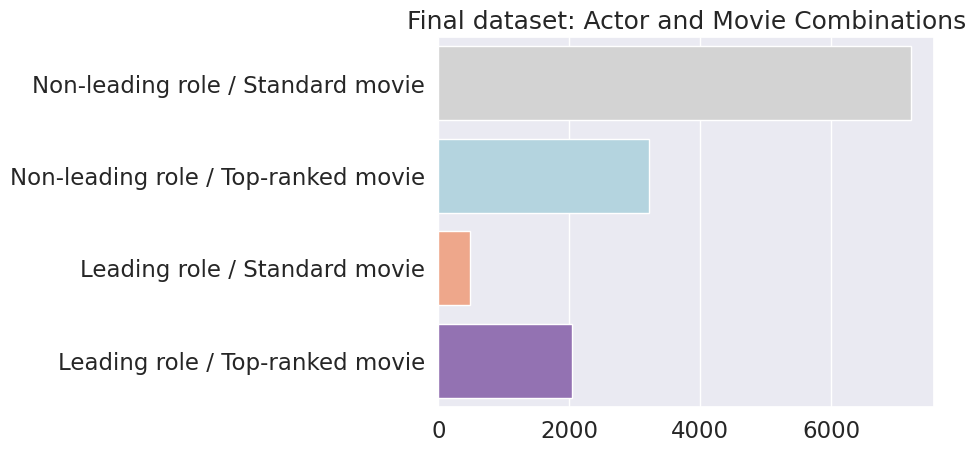

In [579]:
# Pivot table to rearrange data for heatmap
combination_columns = ['Non-leading role / Standard movie',
                       'Non-leading role / Top-ranked movie',
                       'Leading role / Standard movie',
                       'Leading role / Top-ranked movie'
                        ]
colors = ['lightgray', 'lightblue','lightsalmon', 'tab:purple']

df_stats[combination_columns[0]] = (df_stats.top_actor_0==0)&(df_stats.top_movie_0==0)
df_stats[combination_columns[1]] = (df_stats.top_actor_0==0)&(df_stats.top_movie_0==1)
df_stats[combination_columns[2]] = (df_stats.top_actor_0==1)&(df_stats.top_movie_0==0)
df_stats[combination_columns[3]] = (df_stats.top_actor_0==1)&(df_stats.top_movie_0==1)
sns.set(font_scale=1.5)
sns.barplot(df_stats[combination_columns].sum(), orient='h', palette=colors);

plt.title('Final dataset: Actor and Movie Combinations')
# plt.xlabel('Count')
plt.ylabel('')

Plot actor development by individual actors

In [461]:
features_described = ['Standard Actor', 'Principal Actor', 'Standard Movie', 'Top Ranked Movie']

In [462]:
def plot_progress_by_actor(actor_name, cols):
  fig = plt.figure(figsize=(15,3))

  max_count = int(df_stats[cols].max().max())
  df_plot = df_stats[df_stats.actor_name==actor_name]

  ax = fig.add_subplot(1,2,1)

  df_melted = df_plot[['year']+cols[:2]].melt(id_vars=['year'], var_name='Feature', value_name='Count')
  df_melted.loc[df_melted.Feature=='top_actor_0', 'Feature'] = features_described[0]
  df_melted.loc[df_melted.Feature=='top_actor_1', 'Feature'] = features_described[1]

  sns.barplot(data=df_melted, x='year', y='Count', hue='Feature', palette=ONEHOT_FEATURES_PALETTE[:2])
  plt.yticks(range(max_count+1));
  plt.title(f'{actor_name} - Principal Vs. Standard Roles')
  plt.xticks(rotation='vertical')
  plt.legend(title='')
  plt.xlabel('')

  ax = fig.add_subplot(1,2,2)

  df_melted = df_plot[['year']+cols[2:]].melt(id_vars=['year'], var_name='Feature', value_name='Count')
  df_melted.loc[df_melted.Feature=='top_movie_0', 'Feature'] = features_described[2]
  df_melted.loc[df_melted.Feature=='top_movie_1', 'Feature'] = features_described[3]


  sns.barplot(data=df_melted, x='year', y='Count', hue='Feature', palette=ONEHOT_FEATURES_PALETTE[2:])
  plt.yticks(range(max_count+1));
  plt.title(f'{actor_name} - Top Ranked Vs. Standard Movies');
  plt.xticks(rotation='vertical');
  plt.xlabel('')
  plt.legend(title='')
  plt.tight_layout()


**Christopher Walken**

The left plot shows that he began a few years in small roles and then made mostly movies in which he was one of the principal actors. The right plot shows that most of the movies he participates in are standard and not top-ranked movies.

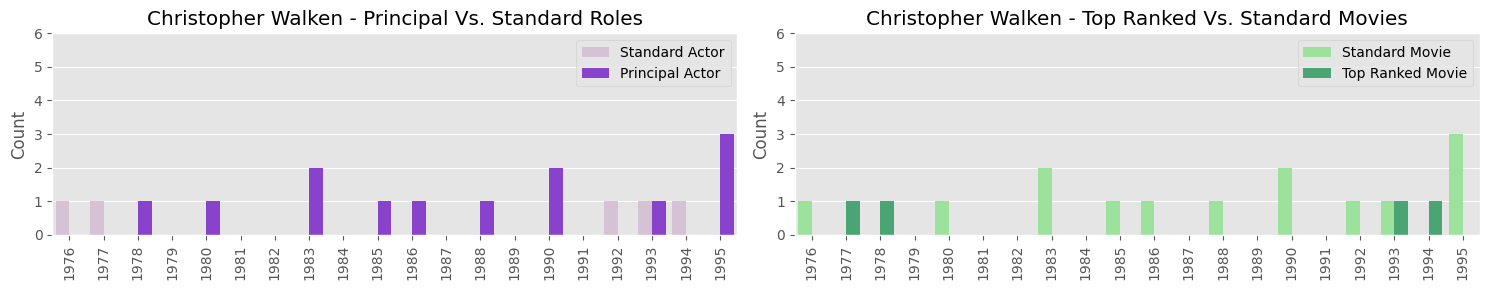

In [463]:
plot_progress_by_actor('Christopher Walken', cols)

**John Travolta**

The left plot shows that he only participates movies if he's one of the principal actor. The right plot shows that his movies are rarely ranked high.

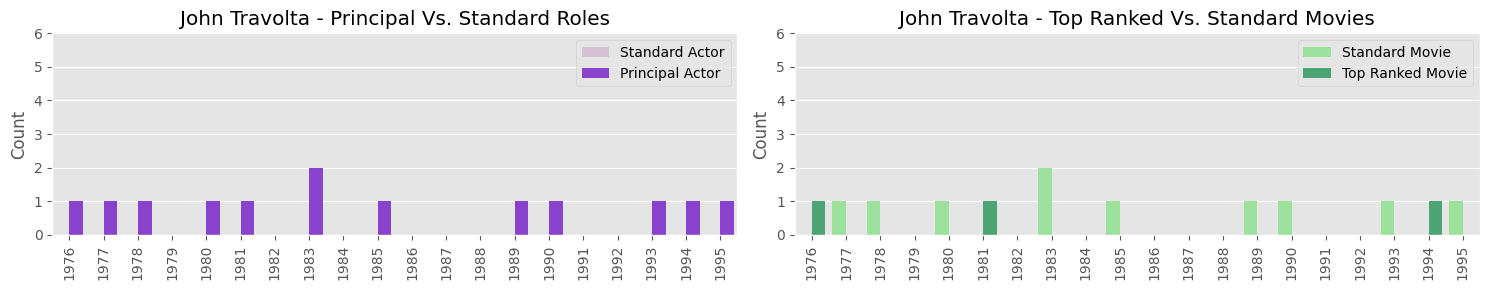

In [315]:
plot_progress_by_actor('John Travolta', cols)

**Tom Hanks**

Also does mainly principal actor roles (left), but his career developed from only standard movies to mainly top-ranked movies.


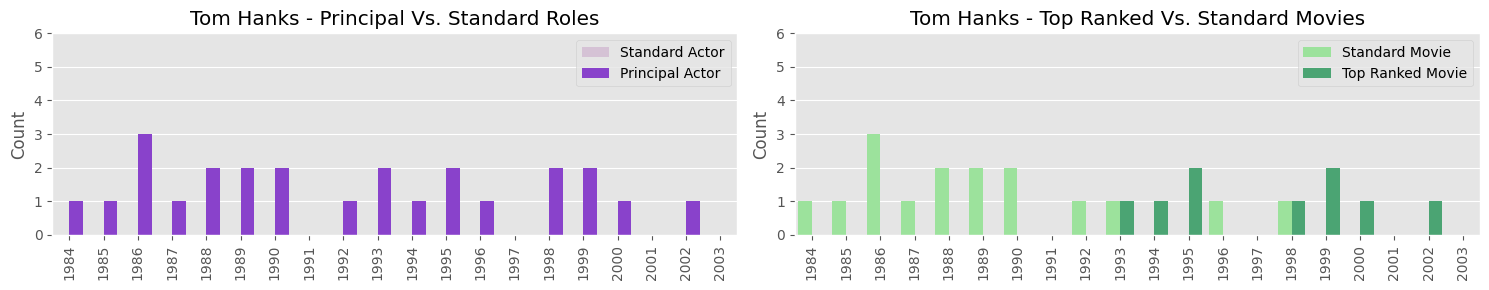

In [316]:
plot_progress_by_actor('Tom Hanks', cols)

**Clark Gregg**

Only not leading actor and not highly ranked movies.

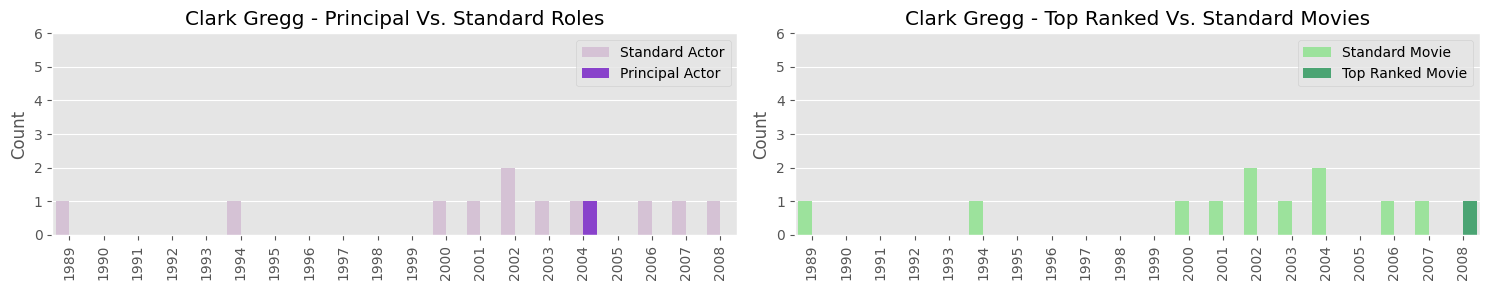

In [259]:
plot_progress_by_actor('Clark Gregg', cols)

## Clustering

To check the career development of the selected actors and movies, I will perform a **time series clustering**. The time series data that are closely grouped together are clustered.



In [234]:
# reshape to: <number of actors>, <CAREER_LENGTH>, <number of features>
X = df_stats[cols].values.reshape(-1, CAREER_LENGTH, 4)
X_scaled = X
X.shape

(752, 20, 4)

In [301]:
# Euclidean Dynamic Time Warping

scores=[]
cluster_range = range(2, 10)
for n_clusters in cluster_range:
  print(f"{datetime.now().strftime('%H:%M:%S')} N={n_clusters}: fit")
  model = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=SEED, metric="dtw")
  y_pred = model.fit_predict(X_scaled)
  #print(f"{datetime.now().strftime('%H:%M:%S')} N={n_clusters}: compute silhouette score")
  score = model.inertia_
  scores.append(score)

09:43:32 N=2: fit
09:43:45 N=3: fit
09:44:10 N=4: fit
09:44:29 N=5: fit
09:44:48 N=6: fit
09:45:03 N=7: fit
09:45:33 N=8: fit
09:45:52 N=9: fit


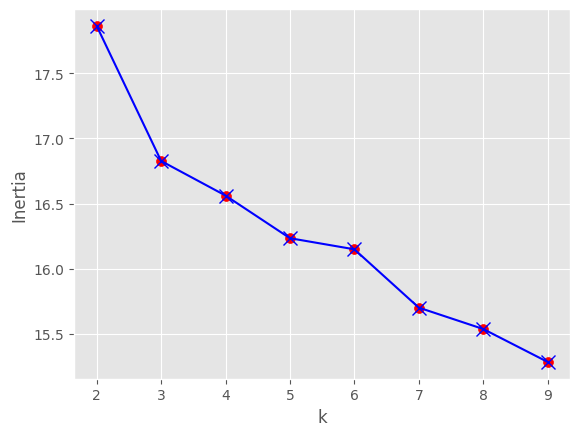

In [302]:
# Elbow
plt.plot(cluster_range, scores, 'bx-', markersize=10)
plt.scatter(cluster_range, scores, color='red', s=50, marker='o')
plt.xticks(cluster_range)
plt.xlabel('k')
plt.ylabel('Inertia');#Silhouette Score


In [487]:
n_clusters = 7

In [488]:
model = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=SEED, metric="dtw")
y_pred = model.fit_predict(X_scaled)

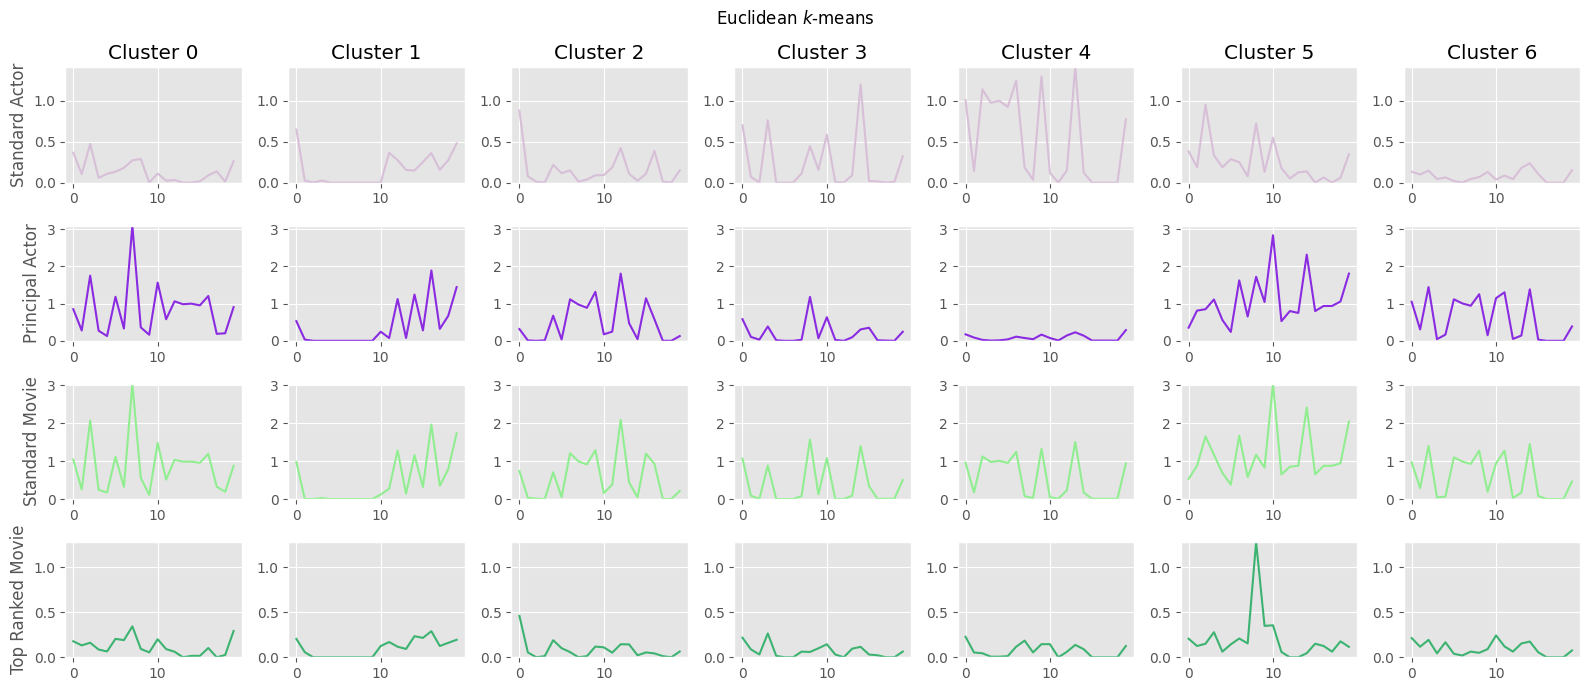

In [489]:
plt.figure(figsize=(16, 7))
#plot_max = np.round(np.max(model.cluster_centers_),1)+0.1

plot_max = np.max(model.cluster_centers_, axis=(0,1))
# plot_max = np.round(plot_max,2) + 0.2

for i in range(n_clusters*4):
    cluster_id = i%n_clusters
    plt.subplot(4, n_clusters, i + 1)
    feature_id = i//n_clusters
    # plt.plot(model.cluster_centers_[cluster_id][:,feature_id].ravel(), color=ONEHOT_FEATURES_PALETTE[feature_id])
    # sns.barplot(model.cluster_centers_[cluster_id][:,feature_id].ravel(), color=ONEHOT_FEATURES_PALETTE[feature_id])
    sns.lineplot(model.cluster_centers_[cluster_id][:,feature_id].ravel(), color=ONEHOT_FEATURES_PALETTE[feature_id])

    plt.ylim(0, plot_max[feature_id])
    if feature_id==0:
      plt.title(f"Cluster {cluster_id}")
    if cluster_id==0:
      plt.ylabel(features_described[feature_id])
plt.suptitle("Euclidean $k$-means")
plt.tight_layout()

Let's follow the feature and cluster graph to try to describe what we see:

**Actors in Cluster 0**: Highly active in the first 10 years as a principal actor and some top-ranked movies, then still highly active but less high-ranked movies.

**Actors in Cluster 1**: Slow starters, become stars after a long pause.

**Actors in Cluster 2**:Great first years as a standard actor in top-ranked movie, then a career mainly as principal actor, in mixed movie types.

**Actors in Cluster 3**:Like 2 with a more spiked standard activity in the last years.

**Actors in Cluster 4**:Staying Standard

**Actors in Cluster 5**:Switching from standard to leading actor

**Actors in Cluster 6**:Beginning and staying a leading actor

In [490]:
actors_clusters = pd.DataFrame(data=zip(df_stats.actor_name.unique(), y_pred), columns=['actor_name', 'cluster'])

Calculate top examples per cluster

In [522]:
distances_to_centers = model.transform(X)
top_actors_per_cluster_id = []
n = 5
for cluster_id in range(n_clusters):
  cluster_id_indexes = np.where(y_pred==cluster_id)[0]
  distances_to_centers_of_cluster_id = distances_to_centers[cluster_id_indexes]
  top_n = np.argsort(distances_to_centers_of_cluster_id[:, cluster_id])[:n]
  top_n_global_indexes = cluster_id_indexes[top_n]
  actors_of_cluster_id = actors_clusters[actors_clusters.index.isin(top_n_global_indexes)].actor_name.tolist()
  top_actors_per_cluster_id.append(actors_of_cluster_id)
  print(cluster_id, actors_of_cluster_id)


0 ['Chevy Chase', 'Denise Richards', 'Ice Cube', 'Pierce Brosnan', 'Rupert Everett']
1 ['David Morse', 'James Woods', 'Joshua Leonard', 'Melanie Griffith', 'Milla Jovovich']
2 ['JoBeth Williams', 'John Corbett', 'Lena Headey', 'Meg Ryan', 'Morris Chestnut']
3 ['David Arquette', 'Ed Begley Jr.', 'Eliza Dushku', 'Ethan Embry', 'Fisher Stevens']
4 ['Dale Dye', 'Damian Young', 'Lin Shaye', 'Matt Malloy', 'Tom Bower']
5 ['Aaron Eckhart', 'Cameron Diaz', 'Ewan McGregor', 'Laura Linney', 'Will Ferrell']
6 ['Christopher Lambert', 'Glenn Close', 'Kathleen Turner', 'Natasha Richardson', 'Roger Moore']


In [523]:
df_stats['cluster'] = df_stats['actor_name'].reset_index().merge(actors_clusters, on='actor_name').cluster
df_stats_top = df_stats[df_stats.actor_name.isin(list(chain.from_iterable(top_actors_per_cluster_id)))]

## Visualize the top actors per cluster

Find the actors image url-s using google search

In [547]:
def get_image_urls(query, num_images=5):
    search_url = f"https://www.google.com/search?q={query}&tbm=isch"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}

    # Perform a GET request to fetch the search results page
    response = requests.get(search_url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract image URLs from the search results
    image_urls = []
    for img in soup.find_all('img', limit=num_images):
        image_urls.append(img['src'])

    return image_urls

actor_names = list(chain.from_iterable(top_actors_per_cluster_id))

# Perform image search for each actor name
actor_image_urls = {}
for actor_name in actor_names:
    image_urls = get_image_urls(actor_name)
    actor_image_urls[actor_name] = image_urls

# Display the URLs
for actor_name, urls in actor_image_urls.items():
    print(f"{actor_name}: {urls}")

Chevy Chase: ['/images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif', 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSFlzw6g4iMf3FcVjTeWTrldTYc1DE05AEjsO-hwFSgcddCUozZUd_kZcsK8WA&s', 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRBVqESV7A5MEVB-62O5RisJhswD6DO0ZJ4BWGlBphjCTqY71IHhn89425BI9U&s', 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQsyZAN3YWlLx3r5oitgrtWMAJYjoK2GO0PfQP6PILkV__K6T-QXYFG2wzJ-Cw&s', 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRjLoCs5ISHuUHXNLy4HNhkqz_9Nnc98oBTuPA26T9USu1WssTM-Ll4Fa77eiM&s']
Denise Richards: ['/images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif', 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRxoUxRb-ah9w1CCqbfDRkId1ahC30jOw8t7UBspzJgk3_-q8NaiB5gUmMOng&s', 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR1d97A_uAkDPNvVdzLZKKdLcFW87Y6iA1u3BtZlQAY_faQguZ0xgKdL66uEUQ&s', 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ4LGpH_wcpXbI3SML5Bgjl4uSpSBxbCU

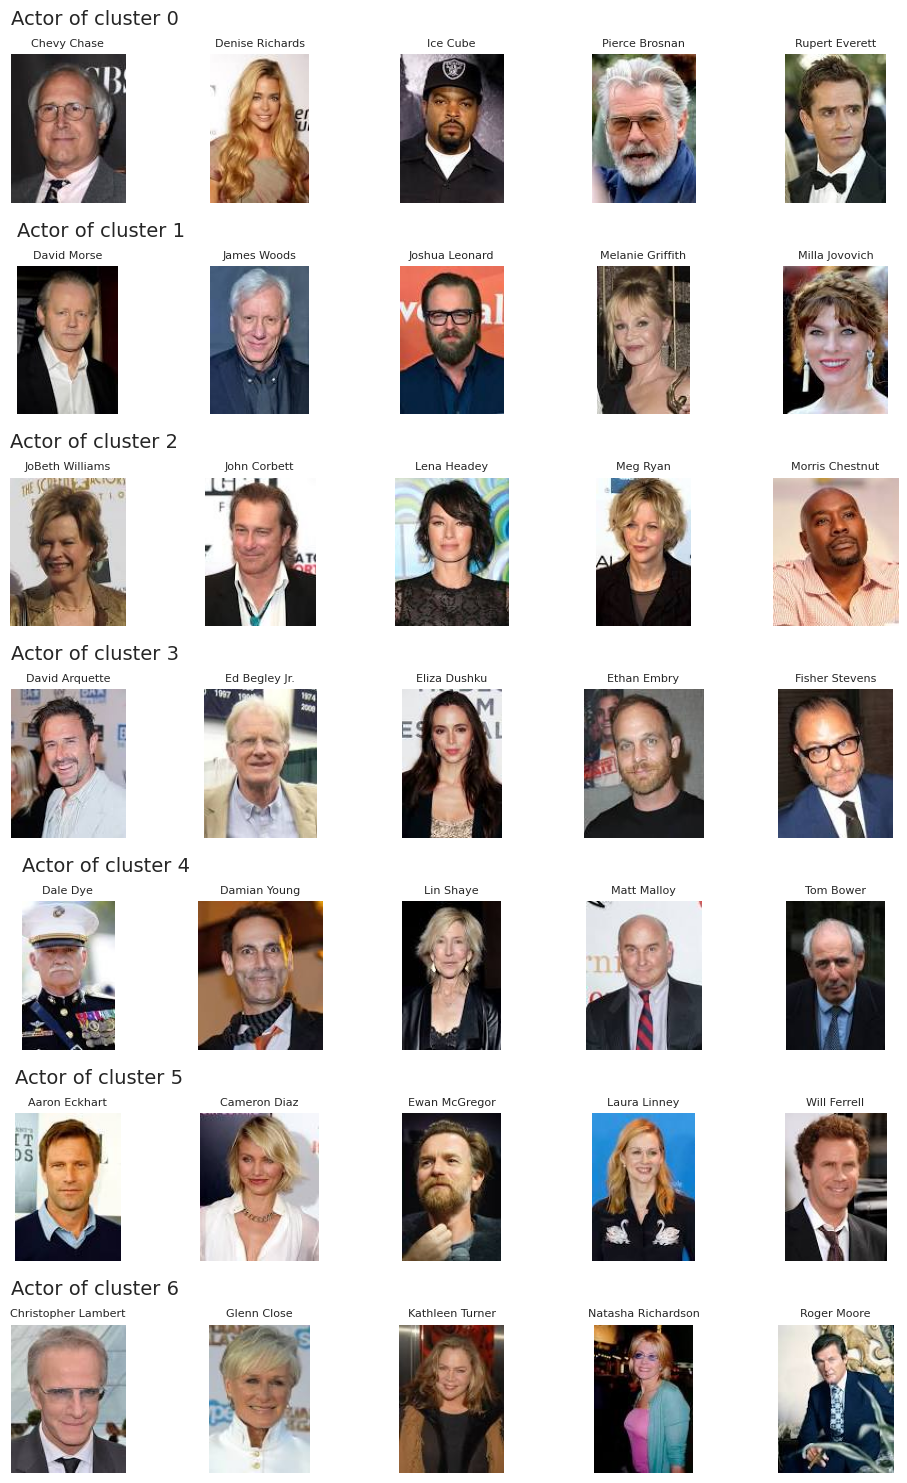

In [576]:

fig = plt.figure(figsize=(10,15))
counter = 1

for i in range(n_clusters):
    for j in range(n):

        ax = fig.add_subplot(n_clusters, n, counter)
        if j==0:
          ax.set_title(f"Actor of cluster {i}\n", fontsize=14, loc='left')
        counter+=1

        # Get the URL
        actor_name = top_actors_per_cluster_id[i][j]
        url = actor_image_urls[actor_name]

        # Download the image
        response = requests.get(url[1])
        img = Image.open(BytesIO(response.content))

        # Display the image
        # axs[i, j].imshow(img)
        plt.imshow(img)
        plt.axis('off')

        # Add name per image
        plt.title(actor_name, fontsize=8)

plt.tight_layout()